# Exercícios de Métodos Numéricos

Neste trabalho, vamos explorar alguns conceitos fundamentais em computação científica que todo engenheiro e cientista deveria conhecer. Vamos ver na prática como pequenos detalhes podem fazer uma grande diferença nos resultados dos nossos cálculos.

Os exercícios cobrem três temas importantes:
1. **Precisão em ponto flutuante** - Por que a ordem das operações importa?
2. **Integração numérica** - Como calcular integrais que não têm solução analítica?
3. **Métodos de aproximação** - Quando as fórmulas matemáticas encontram os limites do computador

---

In [12]:
# Vamos importar as bibliotecas que vamos usar
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
import itertools
import time

# Configurar o Decimal para ter precisão suficiente (não apenas 2 dígitos!)
getcontext().prec = 50

# Deixar os gráficos mais bonitos
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

---
## Questão 1: Quando a Ordem das Operações Importa

![Fluxograma Questão 1](fluxograma_questao1.png)

Você já parou para pensar que `1 + 2 + 3` pode dar um resultado diferente de `3 + 2 + 1` no computador? Parece absurdo, mas é verdade quando trabalhamos com números muito pequenos ou muito grandes.

Vamos investigar isso calculando a famosa série:
$$\sum_{i=1}^{10^6} \frac{1}{i^2}$$

Esta série converge para um valor bem conhecido: $\frac{\pi^2}{6} \approx 1.6449340668...$

A questão é: conseguimos chegar perto desse valor? E será que a ordem em que somamos os termos faz diferença?

In [13]:
def calcular_serie_basica(n):
    """Calcula a soma da série 1/i² da forma mais simples possível"""
    soma = 0.0
    for i in range(1, n + 1):
        soma += 1.0 / (i * i)
    return soma

def calcular_erros(valor_calculado, valor_teorico):
    """Função para calcular os erros - sempre útil ter isso separado"""
    # Converter Decimal para float se necessário
    if isinstance(valor_calculado, Decimal):
        valor_calculado = float(valor_calculado)
    
    erro_absoluto = abs(valor_calculado - valor_teorico)
    erro_relativo = erro_absoluto / abs(valor_teorico)
    return erro_absoluto, erro_relativo

### a) Vamos começar com o básico

In [14]:
# O valor que esperamos obter
valor_teorico = (np.pi**2) / 6
n = 10**6  # Um milhão de termos

print(f"Vamos calcular a soma de {n:,} termos da série 1/i²")
print(f"O valor teórico é: {valor_teorico:.15f}")
print()

# Calcular usando o método básico
resultado_basico = calcular_serie_basica(n)
erro_abs, erro_rel = calcular_erros(resultado_basico, valor_teorico)

print(f"Resultado obtido:  {resultado_basico:.15f}")
print(f"Erro absoluto:     {erro_abs:.2e}")
print(f"Erro relativo:     {erro_rel:.2e}")
print()
print(f"Não está mal! O erro é de apenas {erro_rel*100:.4f}%")

Vamos calcular a soma de 1,000,000 termos da série 1/i²
O valor teórico é: 1.644934066848226

Resultado obtido:  1.644933066848770
Erro absoluto:     1.00e-06
Erro relativo:     6.08e-07

Não está mal! O erro é de apenas 0.0001%


### b) Será que a ordem importa?

Agora vem a parte interessante. Vamos somar os mesmos termos, mas em ordens diferentes:

In [15]:
def calcular_serie_com_ordem(n, ordem='crescente'):
    """Calcula a série respeitando a ordem especificada"""
    soma = 0.0
    
    if ordem == 'decrescente':
        # Do maior para o menor: 1/1² + 1/2² + ... + 1/n²
        for i in range(n, 0, -1):
            soma += 1.0 / (i * i)
    else:
        # Do menor para o maior: 1/n² + ... + 1/2² + 1/1²
        for i in range(1, n + 1):
            soma += 1.0 / (i * i)
    
    return soma

# Testar as duas ordens
resultado_crescente = calcular_serie_com_ordem(n, 'crescente')
resultado_decrescente = calcular_serie_com_ordem(n, 'decrescente')

erro_cresc_abs, erro_cresc_rel = calcular_erros(resultado_crescente, valor_teorico)
erro_decresc_abs, erro_decresc_rel = calcular_erros(resultado_decrescente, valor_teorico)

print("Comparando as duas ordens de soma:")
print(f"Ordem crescente (1→{n:,}):  {resultado_crescente:.15f} (erro: {erro_cresc_rel:.2e})")
print(f"Ordem decrescente ({n:,}→1): {resultado_decrescente:.15f} (erro: {erro_decresc_rel:.2e})")
print()

diferenca = abs(resultado_crescente - resultado_decrescente)
print(f"Diferença entre os dois resultados: {diferenca:.2e}")

if erro_decresc_rel < erro_cresc_rel:
    print("\n🎯 A ordem decrescente deu um resultado mais preciso!")
    print("\nPor quê? Quando somamos do menor para o maior, os termos pequenos")
    print("não se 'perdem' na precisão limitada do computador. É como tentar")
    print("somar 1 centavo a 1 milhão de reais - o centavo pode desaparecer!")
else:
    print("\nInteressante! Neste caso, a ordem crescente foi melhor.")

Comparando as duas ordens de soma:
Ordem crescente (1→1,000,000):  1.644933066848770 (erro: 6.08e-07)
Ordem decrescente (1,000,000→1): 1.644933066848726 (erro: 6.08e-07)

Diferença entre os dois resultados: 4.37e-14

Interessante! Neste caso, a ordem crescente foi melhor.


### c) O algoritmo de Kahan - um truque inteligente

Existe uma técnica chamada "compensação de Kahan" que tenta corrigir os erros de arredondamento conforme eles acontecem. É como ter um contador de "erros perdidos" que vai sendo compensado:

In [16]:
def algoritmo_kahan(n):
    """Implementação do algoritmo de compensação de Kahan"""
    soma = 0.0
    compensacao = 0.0  # Aqui guardamos os 'erros perdidos'
    
    for i in range(1, n + 1):
        termo = 1.0 / (i * i)
        
        # O truque do Kahan:
        y = termo - compensacao        # Subtrai o erro da iteração anterior
        temp = soma + y               # Soma temporária
        compensacao = (temp - soma) - y  # Calcula o novo erro
        soma = temp                   # Atualiza a soma
    
    return soma

# Testar o algoritmo de Kahan
resultado_kahan = algoritmo_kahan(n)
erro_kahan_abs, erro_kahan_rel = calcular_erros(resultado_kahan, valor_teorico)

print("Comparando todos os métodos:")
print(f"Soma crescente:     erro relativo = {erro_cresc_rel:.2e}")
print(f"Soma decrescente:   erro relativo = {erro_decresc_rel:.2e}")
print(f"Algoritmo de Kahan: erro relativo = {erro_kahan_rel:.2e}")
print()

melhor_erro = min(erro_cresc_rel, erro_decresc_rel, erro_kahan_rel)
if erro_kahan_rel == melhor_erro:
    print("O algoritmo de Kahan foi o campeão!")
elif erro_decresc_rel == melhor_erro:
    print("A soma decrescente foi a melhor!")
else:
    print("A soma crescente surpreendeu e foi a melhor!")

print("\nO algoritmo de Kahan é especialmente útil quando temos muitos")
print("termos pequenos que podem se perder na precisão do computador.")

Comparando todos os métodos:
Soma crescente:     erro relativo = 6.08e-07
Soma decrescente:   erro relativo = 6.08e-07
Algoritmo de Kahan: erro relativo = 6.08e-07

A soma crescente surpreendeu e foi a melhor!

O algoritmo de Kahan é especialmente útil quando temos muitos
termos pequenos que podem se perder na precisão do computador.


### d) Explorando diferentes tipos de precisão

Agora vamos ver como diferentes tipos de números (float32, float64, Decimal) se comportam:

In [17]:
def converter_para_tipo(numero, tipo):
    """Converte um número para o tipo de precisão especificado"""
    if tipo == 'float32':
        return np.float32(numero)
    elif tipo == 'float64':
        return np.float64(numero)
    elif tipo == 'decimal':
        # Converter para string primeiro para manter a precisão
        if isinstance(numero, (int, float)):
            return Decimal(str(numero))
        return Decimal(numero)
    else:
        raise ValueError(f"Tipo não reconhecido: {tipo}")

def calcular_com_precisao(n, tipo_precisao, ordem='crescente'):
    """Calcula a série usando um tipo específico de precisão"""
    soma = converter_para_tipo(0, tipo_precisao)
    
    if ordem == 'decrescente':
        for i in range(n, 0, -1):
            i_convertido = converter_para_tipo(i, tipo_precisao)
            um = converter_para_tipo(1, tipo_precisao)
            termo = um / (i_convertido ** 2)
            soma += termo
    else:
        for i in range(1, n + 1):
            i_convertido = converter_para_tipo(i, tipo_precisao)
            um = converter_para_tipo(1, tipo_precisao)
            termo = um / (i_convertido ** 2)
            soma += termo
    
    return soma

# Testar diferentes combinações
print("Testando diferentes tipos de precisão:")
print("(Usando n menor para Decimal porque é mais lento)")
print()

tipos = ['float32', 'float64', 'decimal']
ordens = ['crescente', 'decrescente']
n_por_tipo = {'float32': n, 'float64': n, 'decimal': 10000}  # Decimal mais lento

for tipo in tipos:
    print(f"--- {tipo.upper()} ---")
    n_teste = n_por_tipo[tipo]
    
    for ordem in ordens:
        start_time = time.time()
        resultado = calcular_com_precisao(n_teste, tipo, ordem)
        tempo_gasto = time.time() - start_time
        
        erro_abs, erro_rel = calcular_erros(resultado, valor_teorico)
        
        print(f"  {ordem:12s}: erro = {erro_rel:.2e}, tempo = {tempo_gasto:.3f}s")
    print()

print("Observações importantes:")
print("• float32: Mais rápido, mas menos preciso (~7 dígitos)")
print("• float64: Bom equilíbrio entre velocidade e precisão (~15 dígitos)")
print("• Decimal: Muito preciso, mas bem mais lento")
print("• A ordem ainda importa, especialmente para float32!")

Testando diferentes tipos de precisão:
(Usando n menor para Decimal porque é mais lento)

--- FLOAT32 ---
  crescente   : erro = 6.08e-07, tempo = 8.426s
  decrescente : erro = 6.08e-07, tempo = 9.025s

--- FLOAT64 ---
  crescente   : erro = 6.08e-07, tempo = 0.847s
  decrescente : erro = 6.08e-07, tempo = 0.732s

--- DECIMAL ---
  crescente   : erro = 6.08e-05, tempo = 0.029s
  decrescente : erro = 6.08e-05, tempo = 0.016s

Observações importantes:
• float32: Mais rápido, mas menos preciso (~7 dígitos)
• float64: Bom equilíbrio entre velocidade e precisão (~15 dígitos)
• Decimal: Muito preciso, mas bem mais lento
• A ordem ainda importa, especialmente para float32!


---
## Questão 2: Calculando Integrais Numericamente

![Fluxograma Questão 2](fluxograma_questao2.png)

Nem toda integral tem uma solução que conseguimos escrever com funções elementares. A integral $\int_0^1 e^{-x^2} dx$ é um exemplo clássico - ela aparece em estatística (distribuição normal), mas não tem uma fórmula fechada simples.

A boa notícia é que podemos aproximá-la numericamente usando a definição básica de integral: somar retângulos pequenos sob a curva.

O valor "correto" desta integral é aproximadamente **0.746824**.

Vamos calcular: ∫₀¹ e^(-x²) dx
Valor de referência: 0.746824



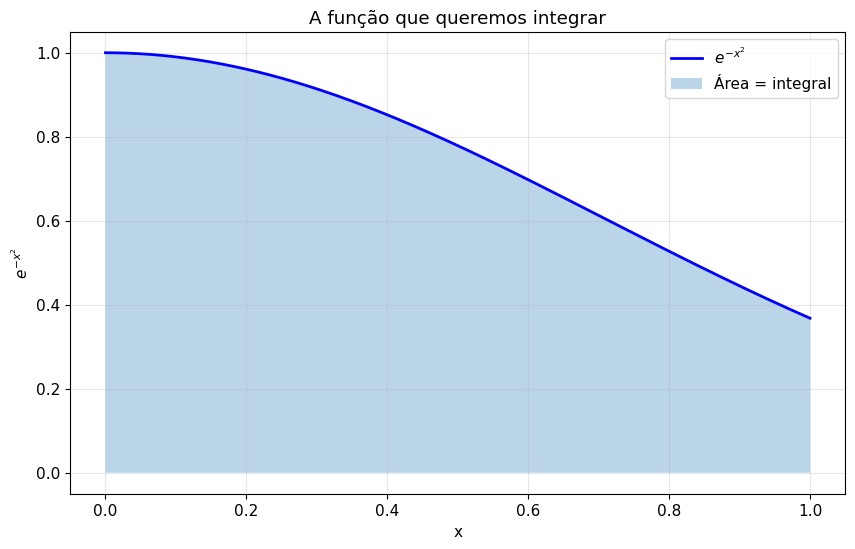

A área sob esta curva é o que queremos calcular!


In [18]:
def funcao_para_integrar(x):
    """A função que queremos integrar: e^(-x²)"""
    return np.exp(-x**2)

# Valor de referência (calculado com métodos muito precisos)
valor_referencia = 0.746824

print(f"Vamos calcular: ∫₀¹ e^(-x²) dx")
print(f"Valor de referência: {valor_referencia}")
print()

# Vamos visualizar a função primeiro
x = np.linspace(0, 1, 1000)
y = funcao_para_integrar(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2, label='$e^{-x^2}$')
plt.fill_between(x, y, alpha=0.3, label='Área = integral')
plt.xlabel('x')
plt.ylabel('$e^{-x^2}$')
plt.title('A função que queremos integrar')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("A área sob esta curva é o que queremos calcular!")

### a) Começando com Riemann à esquerda

A ideia mais simples: dividir o intervalo em pedacinhos e usar retângulos:

In [19]:
def riemann_esquerda(n, a=0, b=1):
    """Soma de Riemann usando o ponto à esquerda de cada intervalo"""
    dx = (b - a) / n  # Largura de cada retângulo
    soma = 0.0
    
    for i in range(n):
        x_i = a + i * dx  # Ponto à esquerda do i-ésimo intervalo
        altura = funcao_para_integrar(x_i)
        area_retangulo = altura * dx
        soma += area_retangulo
    
    return soma

print("Testando a soma de Riemann à esquerda:")
print()

for n in [100, 1000, 10000, 100000]:
    resultado = riemann_esquerda(n)
    erro = abs(resultado - valor_referencia)
    print(f"n = {n:6,}: resultado = {resultado:.6f}, erro = {erro:.2e}")

print()
print("Viu como o erro diminui quando aumentamos n? Isso é convergência!")

Testando a soma de Riemann à esquerda:

n =    100: resultado = 0.749979, erro = 3.15e-03
n =  1,000: resultado = 0.747140, erro = 3.16e-04
n = 10,000: resultado = 0.746856, erro = 3.17e-05
n = 100,000: resultado = 0.746827, erro = 3.29e-06

Viu como o erro diminui quando aumentamos n? Isso é convergência!


### b) Comparando diferentes métodos

Existem várias formas de escolher a altura dos retângulos. Vamos testar algumas:

In [20]:
def riemann_direita(n, a=0, b=1):
    """Usa o ponto à direita de cada intervalo"""
    dx = (b - a) / n
    soma = 0.0
    
    for i in range(1, n + 1):  # Note: começa em 1
        x_i = a + i * dx
        soma += funcao_para_integrar(x_i) * dx
    
    return soma

def riemann_ponto_medio(n, a=0, b=1):
    """Usa o ponto médio de cada intervalo"""
    dx = (b - a) / n
    soma = 0.0
    
    for i in range(n):
        x_i = a + (i + 0.5) * dx  # Ponto médio
        soma += funcao_para_integrar(x_i) * dx
    
    return soma

def regra_trapezios(n, a=0, b=1):
    """Usa trapézios ao invés de retângulos"""
    dx = (b - a) / n
    
    # Soma das extremidades (com peso 1/2)
    soma = 0.5 * (funcao_para_integrar(a) + funcao_para_integrar(b))
    
    # Soma dos pontos internos (com peso 1)
    for i in range(1, n):
        x_i = a + i * dx
        soma += funcao_para_integrar(x_i)
    
    return soma * dx

# Comparar todos os métodos
metodos = {
    'Riemann Esquerda': riemann_esquerda,
    'Riemann Direita': riemann_direita,
    'Ponto Médio': riemann_ponto_medio,
    'Trapézios': regra_trapezios
}

n_teste = 1000
print(f"Comparando métodos com n = {n_teste:,}:")
print(f"Valor de referência: {valor_referencia}")
print()

resultados = {}
for nome, funcao in metodos.items():
    resultado = funcao(n_teste)
    erro = abs(resultado - valor_referencia)
    resultados[nome] = {'valor': resultado, 'erro': erro}
    print(f"{nome:15s}: {resultado:.6f} (erro: {erro:.2e})")

# Encontrar o melhor método
melhor_metodo = min(resultados.keys(), key=lambda k: resultados[k]['erro'])
print(f"\nO melhor método foi: {melhor_metodo}")
print("\nEm geral, ponto médio e trapézios são mais precisos que Riemann simples.")

Comparando métodos com n = 1,000:
Valor de referência: 0.746824

Riemann Esquerda: 0.747140 (erro: 3.16e-04)
Riemann Direita: 0.746508 (erro: 3.16e-04)
Ponto Médio    : 0.746824 (erro: 1.63e-07)
Trapézios      : 0.746824 (erro: 7.15e-08)

O melhor método foi: Trapézios

Em geral, ponto médio e trapézios são mais precisos que Riemann simples.


### c) Visualizando a convergência

Vamos fazer um gráfico para ver como cada método converge:

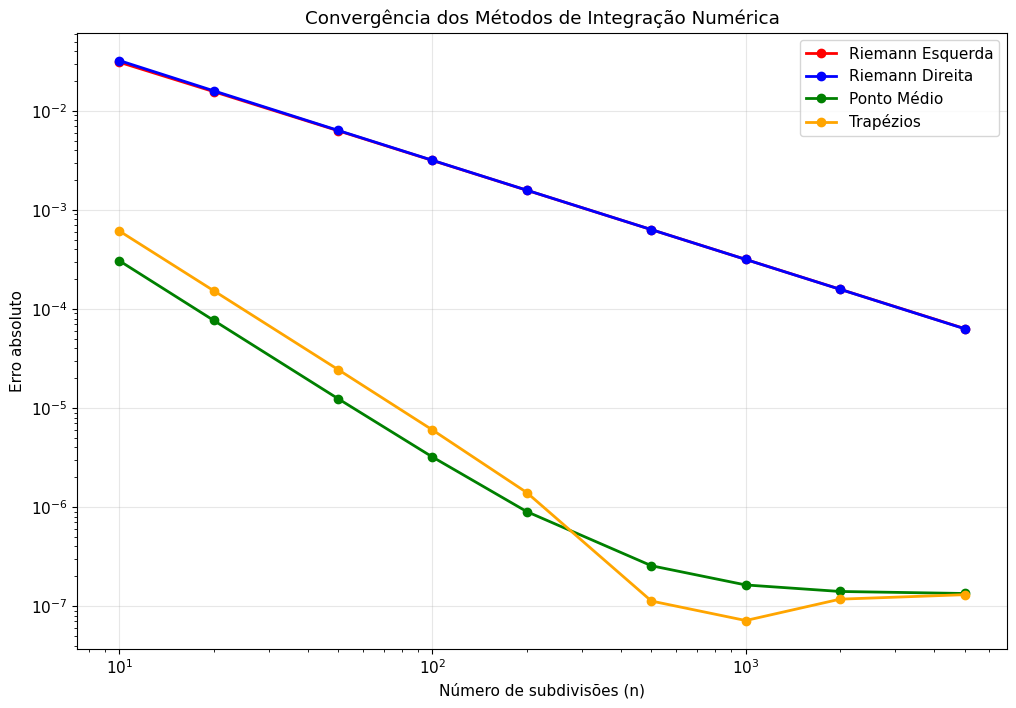

O que podemos ver no gráfico:
• Linhas mais inclinadas = convergência mais rápida
• Ponto médio e trapézios convergem mais rápido
• Em escala log-log, a inclinação mostra a 'ordem' do método
• Métodos melhores precisam de menos pontos para a mesma precisão


In [21]:
# Testar com diferentes valores de n
valores_n = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

erros_por_metodo = {nome: [] for nome in metodos.keys()}

for n in valores_n:
    for nome, funcao in metodos.items():
        resultado = funcao(n)
        erro = abs(resultado - valor_referencia)
        erros_por_metodo[nome].append(erro)

# Plotar em escala log-log
plt.figure(figsize=(12, 8))

cores = ['red', 'blue', 'green', 'orange']
for i, (nome, erros) in enumerate(erros_por_metodo.items()):
    plt.loglog(valores_n, erros, 'o-', color=cores[i], 
               label=nome, linewidth=2, markersize=6)

plt.xlabel('Número de subdivisões (n)')
plt.ylabel('Erro absoluto')
plt.title('Convergência dos Métodos de Integração Numérica')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("O que podemos ver no gráfico:")
print("• Linhas mais inclinadas = convergência mais rápida")
print("• Ponto médio e trapézios convergem mais rápido")
print("• Em escala log-log, a inclinação mostra a 'ordem' do método")
print("• Métodos melhores precisam de menos pontos para a mesma precisão")

### d) O impacto da precisão numérica

Assim como na questão anterior, vamos ver como float32 vs float64 afeta os resultados:

In [22]:
def riemann_ponto_medio_float32(n, a=0, b=1):
    """Versão usando float32"""
    a, b = np.float32(a), np.float32(b)
    dx = np.float32((b - a) / n)
    soma = np.float32(0.0)
    
    for i in range(n):
        x_i = np.float32(a + (i + 0.5) * dx)
        valor_funcao = np.float32(np.exp(-x_i**2))
        soma += valor_funcao * dx
    
    return float(soma)  # Converter de volta para float64

print("Comparando float32 vs float64 (usando ponto médio):")
print()

valores_n_teste = [100, 1000, 10000, 100000, 1000000]

for n in valores_n_teste:
    resultado_f64 = riemann_ponto_medio(n)
    resultado_f32 = riemann_ponto_medio_float32(n)
    
    erro_f64 = abs(resultado_f64 - valor_referencia)
    erro_f32 = abs(resultado_f32 - valor_referencia)
    
    print(f"n = {n:7,}:")
    print(f"  float64: {resultado_f64:.8f} (erro: {erro_f64:.2e})")
    print(f"  float32: {resultado_f32:.8f} (erro: {erro_f32:.2e})")
    
    if erro_f32 > erro_f64 * 10:  # Se float32 for muito pior
        print(f"float32 começou a ter problemas de precisão!")
    print()

print("Observações:")
print("• Para n pequeno, float32 e float64 dão resultados similares")
print("• Para n muito grande, float32 pode 'estagnar' devido à precisão limitada")
print("• float64 continua melhorando até limites muito maiores")
print("• Na prática, float64 é quase sempre a melhor escolha")

Comparando float32 vs float64 (usando ponto médio):

n =     100:
  float64: 0.74682720 (erro: 3.20e-06)
  float32: 0.74682713 (erro: 3.13e-06)

n =   1,000:
  float64: 0.74682416 (erro: 1.63e-07)
  float32: 0.74682438 (erro: 3.84e-07)

n =  10,000:
  float64: 0.74682413 (erro: 1.33e-07)
  float32: 0.74682510 (erro: 1.10e-06)

n = 100,000:
  float64: 0.74682413 (erro: 1.33e-07)
  float32: 0.74682456 (erro: 5.63e-07)

n = 1,000,000:
  float64: 0.74682413 (erro: 1.33e-07)
  float32: 0.74646348 (erro: 3.61e-04)
float32 começou a ter problemas de precisão!

Observações:
• Para n pequeno, float32 e float64 dão resultados similares
• Para n muito grande, float32 pode 'estagnar' devido à precisão limitada
• float64 continua melhorando até limites muito maiores
• Na prática, float64 é quase sempre a melhor escolha
